# Xử lý dữ liệu SPADE


In [1]:
import pandas as pd
import numpy as np
import hashlib
import networkx as nx
from collections import Counter, deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
import random as rd
import json
import lmstudio as lms
import seaborn as sns

## Tiền xử lý


## Chuyển file đã tiền xử lý sang dạng để sử dụng cho WL subtree

In [2]:

def build_graph_from_spade(events, _label = "benign"):
    G = nx.DiGraph()

    for entry in events:
        if 'id' in entry:  # là một node
            node_id = entry['id']
            node_type = entry['type']
            label = entry.get('annotations', {}).get('subtype', node_type)
            G.add_node(node_id, label=label)
        else:  # là một edge
            src = entry['from']
            dst = entry['to']
            label = entry['annotations'].get("operation", entry["type"])
            G.add_edge(src, dst, label=label)
            label = _label

    labels.append(label)
    return G
file_name = "../../dataset/SPADE/benign.json"
with open(file_name, "r", encoding="utf-8") as f:
    logs = json.load(f)
labels = []
label = ""
graphs = []
for log in tqdm(logs, desc="Graphs"):
    if(len(log) > 0):
        graphs.append(build_graph_from_spade(log, _label = "benign"))


Graphs: 100%|██████████| 2855/2855 [00:05<00:00, 505.67it/s] 


In [3]:

def build_graph_from_spade(events, _label = "benign"):
    G = nx.DiGraph()

    for entry in events:
        if 'id' in entry:  # là một node
            node_id = entry['id']
            node_type = entry['type']
            label = entry.get('annotations', {}).get('subtype', node_type)
            G.add_node(node_id, label=label)
        else:  # là một edge
            src = entry['from']
            dst = entry['to']
            label = entry['annotations'].get("operation", entry["type"])
            G.add_edge(src, dst, label=label)
            label = _label

    labels.append(label)
    return G
file_name = "../../dataset/SPADE/reverse_shell.json"
with open(file_name, "r", encoding="utf-8") as f:
    logs = json.load(f)

file_name = "../../dataset/SPADE/benign.json"
for log in tqdm(logs, desc="Graphs"):
    if(len(log) > 0):
        graphs.append(build_graph_from_spade(log, _label = "attack"))


Graphs: 100%|██████████| 520/520 [00:09<00:00, 53.50it/s] 


In [4]:
print(len(labels))

3375


## FlexSketch
Được trình bày trong bài báo [FlexSketch: Estimation of Probability Density for Stationary and Non-Stationary Data Streams](https://doi.org/10.3390/s21041080).

FlexSketch được sử dụng

In [5]:
class FlexSketch:
    def __init__(self, max_bins=100, max_histograms=5):
        self.max_bins = max_bins
        self.max_histograms = max_histograms
        self.histograms = deque()
        self.weights = deque()

    def update(self, label_counter):
        most_common = label_counter.most_common(self.max_bins)
        vector = np.zeros(self.max_bins)
        for i, (_, count) in enumerate(most_common):
            vector[i] = count
        self.histograms.append(vector)
        self.weights.append(1.0)
        if len(self.histograms) > self.max_histograms:
            self.histograms.popleft()
            self.weights.popleft()
        total_weight = sum(self.weights)
        self.weights = deque([w / total_weight for w in self.weights])

    def estimate_vector(self):
        result = np.zeros(self.max_bins)
        for h, w in zip(self.histograms, self.weights):
            result += w * h
        return result

# WL subtree extraction
def wl_subtree_features(graph, k=2):
    node_labels = nx.get_node_attributes(graph, 'label')
    features = {node: [node_labels.get(node, 'N/A')] for node in graph.nodes()}
    current_labels = node_labels.copy()
    for _ in range(k):
        new_labels = {}
        for node in graph.nodes():
            neighbors = sorted(
                [str(current_labels.get(nbr, '')) for nbr in graph.predecessors(node)] +
                [str(current_labels.get(nbr, '')) for nbr in graph.successors(node)]
            )
            combined = str(current_labels.get(node, '')) + "|" + "|".join(neighbors)
            hash_label = hashlib.md5(combined.encode()).hexdigest()
            new_labels[node] = hash_label
            features[node].append(hash_label)
        current_labels = new_labels
    return features

In [6]:
print("Extracting FlexSketch vectors...")
flex_vectors = []
for G in tqdm(graphs, desc="Vectorizing"):
    wl_feats = wl_subtree_features(G, k=3)
    all_labels = []
    for lbls in wl_feats.values():
        all_labels.extend(lbls)
    sketch = FlexSketch(max_bins=100)
    sketch.update(Counter(all_labels))
    flex_vectors.append(sketch.estimate_vector())



Extracting FlexSketch vectors...


Vectorizing: 100%|██████████| 3375/3375 [00:21<00:00, 157.88it/s]


Splitting benign and attack samples...
Standardizing feature vectors...
Training KMeans on benign samples...
Computing anomaly threshold...


Benign distances: 100%|██████████| 2854/2854 [00:00<00:00, 148824.42it/s]


Predicting anomalies...


Predicting: 100%|██████████| 3374/3374 [00:00<00:00, 128239.21it/s]

Evaluating...


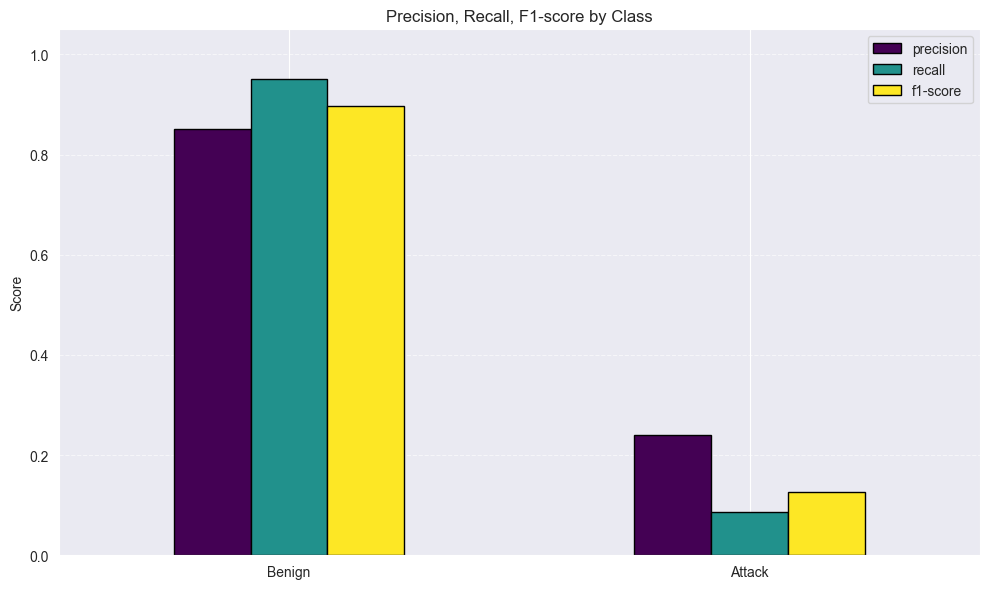

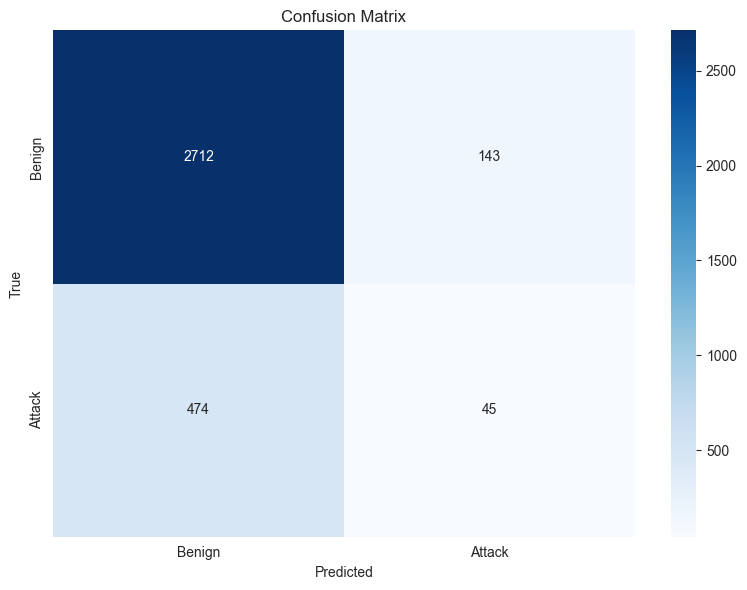


=== Classification Report (Anomaly Detection) ===
{'Benign': {'precision': 0.8512241054613936, 'recall': 0.9499124343257443, 'f1-score': 0.8978645919549744, 'support': 2855.0}, 'Attack': {'precision': 0.2393617021276596, 'recall': 0.08670520231213873, 'f1-score': 0.1272984441301273, 'support': 519.0}, 'accuracy': 0.8171310017783047, 'macro avg': {'precision': 0.5452929037945266, 'recall': 0.5183088183189415, 'f1-score': 0.5125815180425508, 'support': 3374.0}, 'weighted avg': {'precision': 0.7571053777405258, 'recall': 0.8171310017783047, 'f1-score': 0.7793335217946022, 'support': 3374.0}}


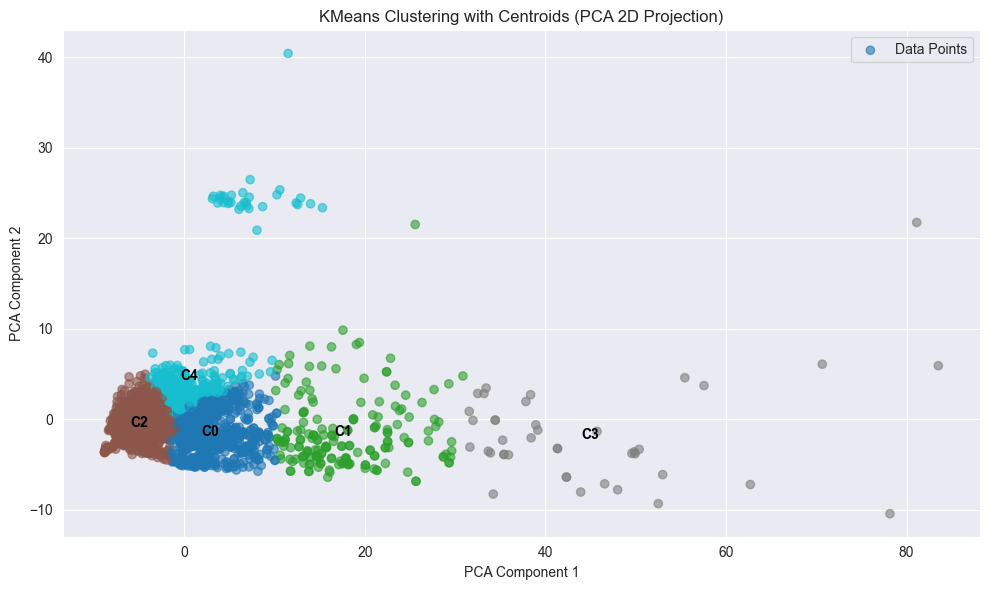

In [7]:
import random

X = np.array(flex_vectors)
y = np.array(labels)

print("Splitting benign and attack samples...")
X_benign = X[y == "benign"]
X_attack = X[y == "attack"] #mo cmt khi co attack
# X_attack = rd.choices(X_attack, k = 50)
# y_attack = ["attack"] * 50

X = np.concatenate([X_benign, X_attack], axis=0) # mo cmt khi co attack
# X = np.concatenate([X_benign], axis=0) # cmt khi chi co benign
# y = ["benign"] * len(labels) + ["attack"] * 50
y = labels
print("Standardizing feature vectors...")
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
#X_attack_scaled = scaler.transform(X_attack)
X_all_scaled = scaler.transform(X)

print("Training KMeans on benign samples...")
kmeans = KMeans(n_clusters=5, random_state=random.randint(1,100))
kmeans.fit(X_benign_scaled)

def min_distance(x):
    return np.min(np.linalg.norm(kmeans.cluster_centers_ - x, axis=1))

print("Computing anomaly threshold...")
benign_dists = [min_distance(x) for x in tqdm(X_benign_scaled, desc="Benign distances")]
threshold = np.percentile(benign_dists, 95)

with open("threshold_spade.json", "w") as f:
    json.dump({"threshold": threshold}, f)

print("Predicting anomalies...")
all_labels = [1 if cls == "attack" else 0 for cls in y]
pred_labels = [1 if min_distance(x) > threshold else 0 for x in tqdm(X_all_scaled, desc="Predicting")]

print("Evaluating...")
if ("benign" in file_name) or ("idle" in file_name):
    all_labels = all_labels[0: -1]

report = classification_report(all_labels, pred_labels, target_names=["Benign", "Attack"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Filter only Benign, Attack
plot_data = df_report.loc[["Benign", "Attack"], ["precision", "recall", "f1-score"]]

# Plot
ax = plot_data.plot(kind="bar", figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

model_path = "kmeans_model_spade.joblib"
scaler_path = "scaler_spade.joblib"

joblib.dump(kmeans, model_path)
joblib.dump(scaler, scaler_path)

print("\n=== Classification Report (Anomaly Detection) ===")
print(report)
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_benign_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Predict cluster labels for visualization
cluster_labels = kmeans.predict(X_benign_scaled)

# Plot clusters with centroids
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, label="Data Points")
#plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='yellow', marker='X', s=200, edgecolor='black', label="Centroids")

# Annotate centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'C{i}', fontsize=10, ha='center', va='center', weight='bold', color='black')

plt.title("KMeans Clustering with Centroids (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Thử nghiệm trên input thực tế

In [8]:

print(threshold)

total = 0
dis = []
idx = []
index = 0
def detect(x):
    global total
    dist = min_distance(x)
    # if dist > dis[0]:
    #     dis[1] = dis[0]
    #     idx[1] = idx[0]
    #     dis[0] = dist
    #     idx[0] = index
    # elif dist > dis[1]:
    #     dis[1] = dist
    #     idx[1] = index
    print(dist)
    # total += dist
    # if dist < threshold:
    dis.append([dist, index])
    return dist > threshold


for G in X_all_scaled:
    if labels[index] == "attack":
        if detect(G):
            print("attack")
            idx.append(index - 2855)

        else:
            print("benign")
    index += 1



print(idx)
print(len(idx))

8.45512218705233
4.152464616883852
benign
4.303686935726164
benign
5.215706575889135
benign
10.58484319017587
attack
4.710989597928612
benign
3.562420695366866
benign
4.796168524607129
benign
18.413692631208427
attack
4.146587023075667
benign
5.955259510327712
benign
5.452755231478155
benign
4.53809570378792
benign
3.5137218666455876
benign
2.1560521574572107
benign
3.4954426829776937
benign
6.084331291835998
benign
4.730684090084581
benign
10.390714424007284
attack
5.390765774595254
benign
5.980972047780728
benign
5.317931570901356
benign
10.371783135379722
attack
3.3278255489130784
benign
4.946752814725483
benign
4.0671992349037955
benign
4.349803736758478
benign
60.474602110668435
attack
4.161024874557771
benign
3.9119510127300137
benign
5.247157061582817
benign
3.375110966091555
benign
4.418846289561478
benign
3.784197245734307
benign
4.110865325670072
benign
13.331300979716525
attack
3.713986964879564
benign
3.99024923546318
benign
3.5814245496231156
benign
3.9516894273272447
beni